# Automatidata project

Assuming I am a data professional in a data consulting firm called Automatidata. Their client, the New York City Taxi & Limousine Commission (New York City TLC), has requested that I build a machine learning model to predict if a customer will not leave a tip. They want to use the model in an app that will alert taxi drivers to customers who are unlikely to tip, since drivers depend on tips.

# Build a machine learning model

<div></div>

## PACE: Plan 

Consider the following questions:

**Question 1: What are you being asked to do?**
- Predict if a customer will **not** leave a tip.

**Question 2: What are the ethical implications of the model? What are the consequences of your model making errors?**
- **What is the likely effect of the model when it predicts a false negative (i.e., when the model says a customer will give a tip, but they actually won't)?**
    - Drivers who didn't receive tips will probably be upset that the app told them a customer would leave a tip. If it happened often, drivers might not trust the app.
    
- **What is the likely effect of the model when it predicts a false positive (i.e., when the model says a customer will not give a tip, but they actually will)?**
    - Drivers are unlikely to pick up people who are predicted to not leave tips. Customers will have difficulty finding a taxi that will pick them up, and might get angry at the taxi company. Even when the model is correct, people who can't afford to tip will find it more difficult to get taxis, which limits the accessibility of taxi service to those who pay extra.
    
**Question 3: Do the benefits of such a model outweigh the potential problems?**
- It's not good to disincentivize drivers from picking up customers. It could also cause a customer backlash. The problems seem to outweigh the benefits.
    
**Question 4: Would you proceed with the request to build this model? Why or why not?**
- No. Effectively limiting equal access to taxis is ethically problematic, and carries a lot of risk.
    
**Question 5: Can the objective be modified to make it less problematic?**
- We can build a model that predicts the most generous customers. This could accomplish the goal of helping taxi drivers increase their earnings from tips while preventing the wrongful exclusion of certain people from using taxis.

Suppose I were to modify the modeling objective so, instead of predicting people who won't tip at all, I predicted people who are particularly generous&mdash;those who will tip 20% or more? Consider the following questions:

**Question 1: What features do you need to make this prediction?**
- Ideally, we'd have behavioral history for each customer, so we could know how much they tipped on previous taxi rides. We'd also want times, dates, and locations of both pickups and dropoffs, estimated fares, and payment method.

**Question 2: What would be the target variable?**
- The target variable would be a binary variable (1 or 0) that indicates whether or not the customer is expected to tip ≥ 20%.

**Question 3: What are the essential metrics to indicate the success of the model?**
- This is a supervised learning, classification task. We could use accuracy, precision, recall, F-score, area under the ROC curve, or a number of other metrics. However, we don't have enough information at this time to know which are most appropriate. We need to know the class balance of the target variable.

### Task 1. Imports and data loading

Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# For XGB feature importance plot
from xgboost import plot_importance

# For saving models
import pickle 

Begin by reading in the data. There are two dataframes: one containing the original data, the other containing the mean durations, mean distances, and predicted fares from the previous project called `nyc_preds_means.csv`.

In [2]:
# Load dataset into dataframe
df0 = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')

# Import predicted fares and mean distance and duration from previous course
nyc_preds_means = pd.read_csv('nyc_preds_means.csv')

df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


#### Join the two dataframes

Join the two dataframes using any suitable method.

In [3]:
# Copy df0 and assign to df1
df1 = df0.copy()

# Merge datasets, inner join on index
df1 = df1.merge(nyc_preds_means,
                left_index=True,
                right_index=True)

df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


<div></div>

## PACE: Analyze

### Task 2. Feature engineering

Call `info()` on the dataframe.

In [4]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

We know from previous EDA that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, we'll need to sample the data to select only the customers who pay with credit card. 

Use a Boolean mask to filter `df1` so it contains only customers who paid with credit card.

In [5]:
# Subset the data to isolate only customers who paid by credit card
df1 = df1[df1['payment_type']==1]

#### Target

Notice that there isn't a column that indicates tip percent, which is what we need to create the target variable. We'll have to engineer it.

Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  

$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$

In [6]:
# Create tip % col
df1['tip_percent'] = df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount'])

Now create another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

1. Begin by making the `generous` column a copy of the `tip_percent` column.
2. Reassign the column by converting it to Boolean (True/False).
3. Reassign the column by converting Boolean to binary (1/0).

In [7]:
# Create 'generous' col (target)
df1['generous'] = df1['tip_percent']
df1['generous'] = (df1['generous'] >= 0.2)
df1['generous'] = df1['generous'].astype(int)

#### Create day column

Next, we're going to be working with the pickup and dropoff columns.

Convert the `tpep_pickup_datetime` column to datetime.

In [8]:
#import datetime
import datetime as dt

# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

Create a `day` column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [9]:
# Create a 'day' col
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200000,1,saturday
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238095,1,tuesday
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.198630,0,friday
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300000,1,sunday
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200000,1,saturday


#### Create time of day columns

Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)
`daytime` = [10:00&ndash;16:00)
`pm_rush` = [16:00&ndash;20:00)
`nighttime` = [20:00&ndash;06:00)

To do this, first create the four columns. For now, each new column should be identical and contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [10]:
# Create 'am_rush' col
df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df1['pm_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df1['nighttime'] = df1['tpep_pickup_datetime'].dt.hour

We'll need to write four functions to convert each new column to binary (0/1). Begin with `am_rush`. Complete the function so if the hour is between (06:00–10:00), it returns 1, otherwise, it returns 0.

In [11]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

Now, apply the `am_rush()` function to the `am_rush` series to perform the conversion. Print the first five values of the column to make sure it did what we expected it to do.

**Note:** Be careful! If we run this cell twice, the function will be reapplied and the values will all be changed to 0.

In [12]:
# Apply 'am_rush' function to the 'am_rush' series
df1['am_rush'] = df1.apply(am_rush, axis=1)
df1['am_rush'].head()

0    1
1    0
2    1
3    0
5    0
Name: am_rush, dtype: int64

Write functions to convert the three remaining columns and apply them to their respective series.

In [13]:
# Define 'daytime()' conversion function [10:00–16:00)
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

In [14]:
# Apply 'daytime' function to the 'daytime' series
df1['daytime'] = df1.apply(daytime, axis=1)

In [15]:
# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

In [16]:
# Apply 'pm_rush' function to the 'pm_rush' series
df1['pm_rush'] = df1.apply(pm_rush, axis=1)

In [17]:
# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24 or 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

In [18]:
# Apply 'nighttime' function to the 'nighttime' series
df1['nighttime'] = df1.apply(nighttime, axis=1)

#### Create month column

Now, create a `month` column that contains only the abbreviated name of the month when each passenger was picked up, then convert the result to lowercase.

In [19]:
# Create 'month' col
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

Examine the first five rows of our dataframe.

In [20]:
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200000,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238095,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.198630,0,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300000,1,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200000,1,saturday,0,0,0,1,mar


#### Drop columns

Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed. This includes information like payment type, trip distance, tip amount, tip percentage, total amount, toll amount, etc. The target variable (`generous`) must remain in the data because it will get isolated as the `y` data for modeling.

In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 22698
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             15265 non-null  int64         
 1   VendorID               15265 non-null  int64         
 2   tpep_pickup_datetime   15265 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  15265 non-null  datetime64[ns]
 4   passenger_count        15265 non-null  int64         
 5   trip_distance          15265 non-null  float64       
 6   RatecodeID             15265 non-null  int64         
 7   store_and_fwd_flag     15265 non-null  object        
 8   PULocationID           15265 non-null  int64         
 9   DOLocationID           15265 non-null  int64         
 10  payment_type           15265 non-null  int64         
 11  fare_amount            15265 non-null  float64       
 12  extra                  15265 non-null  float64       
 13  m

In [22]:
# Drop columns
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int64(10), object(2)
memory usage: 1.9+ MB


#### Variable encoding

Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, we'll first need to convert them to `type(str)`. 

1. Define a variable called `cols_to_str`, which is a list of the numeric columns that contain categorical information and must be converted to string: `RatecodeID`, `PULocationID`, `DOLocationID`.
2. Write a for loop that converts each column in `cols_to_string` to string.


In [23]:
# 1. Define list of cols to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_str:
    df1[col] = df1[col].astype('str')

Now convert all the categorical columns to binary.

1. Call `get_dummies()` on the dataframe and assign the results back to a new dataframe called `df2`. Don't use the `drop_first` parameter.


In [24]:
# Convert categoricals to binary
df2 = pd.get_dummies(df1, drop_first=True)
df2.head()

,passenger_count,mean_duration,mean_distance,predicted_fare,generous,am_rush,daytime,pm_rush,nighttime,VendorID_2,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5,RatecodeID_99,PULocationID_10,PULocationID_100,PULocationID_106,PULocationID_107,PULocationID_112,PULocationID_113,PULocationID_114,PULocationID_116,PULocationID_12,PULocationID_123,PULocationID_125,PULocationID_127,PULocationID_128,PULocationID_129,PULocationID_13,PULocationID_130,PULocationID_131,PULocationID_132,PULocationID_133,PULocationID_134,PULocationID_135,PULocationID_137,PULocationID_138,PULocationID_140,PULocationID_141,PULocationID_142,PULocationID_143,PULocationID_144,PULocationID_145,PULocationID_146,PULocationID_148,PULocationID_151,PULocationID_152,PULocationID_153,PULocationID_158,PULocationID_161,PULocationID_162,PULocationID_163,PULocationID_164,PULocationID_166,PULocationID_17,PULocationID_170,PULocationID_173,PULocationID_179,PULocationID_181,PULocationID_186,PULocationID_188,PULocationID_189,PULocationID_190,PULocationID_193,PULocationID_196,PULocationID_208,PULocationID_209,PULocationID_211,PULocationID_213,PULocationID_216,PULocationID_218,PULocationID_223,PULocationID_224,PULocationID_225,PULocationID_226,PULocationID_229,PULocationID_230,PULocationID_231,PULocationID_232,PULocationID_233,PULocationID_234,PULocationID_236,PULocationID_237,PULocationID_238,PULocationID_239,PULocationID_24,PULocationID_243,PULocationID_244,PULocationID_246,PULocationID_247,PULocationID_249,PULocationID_25,PULocationID_255,PULocationID_256,PULocationID_258,PULocationID_260,PULocationID_261,PULocationID_262,PULocationID_263,PULocationID_264,PULocationID_265,PULocationID_28,PULocationID_33,PULocationID_35,PULocationID_36,PULocationID_37,PULocationID_4,PULocationID_40,PULocationID_41,PULocationID_42,PULocationID_43,PULocationID_45,PULocationID_48,PULocationID_49,PULocationID_50,PULocationID_52,PULocationID_57,PULocationID_61,PULocationID_62,PULocationID_65,PULocationID_66,PULocationID_68,PULocationID_7,PULocationID_70,PULocationID_74,PULocationID_75,PULocationID_79,PULocationID_80,PULocationID_82,PULocationID_87,PULocationID_88,PULocationID_90,PULocationID_91,PULocationID_92,PULocationID_93,PULocationID_95,PULocationID_97,DOLocationID_10,DOLocationID_100,DOLocationID_102,DOLocationID_106,DOLocationID_107,DOLocationID_11,DOLocationID_112,DOLocationID_113,DOLocationID_114,DOLocationID_116,DOLocationID_117,DOLocationID_118,DOLocationID_119,DOLocationID_12,DOLocationID_120,DOLocationID_121,DOLocationID_123,DOLocationID_124,DOLocationID_125,DOLocationID_126,DOLocationID_127,DOLocationID_129,DOLocationID_13,DOLocationID_130,DOLocationID_131,DOLocationID_132,DOLocationID_133,DOLocationID_134,DOLocationID_135,DOLocationID_136,DOLocationID_137,DOLocationID_138,DOLocationID_14,DOLocationID_140,DOLocationID_141,DOLocationID_142,DOLocationID_143,DOLocationID_144,DOLocationID_145,DOLocationID_146,DOLocationID_147,DOLocationID_148,DOLocationID_15,DOLocationID_151,DOLocationID_152,DOLocationID_153,DOLocationID_157,DOLocationID_158,DOLocationID_159,DOLocationID_16,DOLocationID_160,DOLocationID_161,DOLocationID_162,DOLocationID_163,DOLocationID_164,DOLocationID_166,DOLocationID_168,DOLocationID_169,DOLocationID_17,DOLocationID_170,DOLocationID_173,DOLocationID_174,DOLocationID_175,DOLocationID_177,DOLocationID_178,DOLocationID_179,DOLocationID_180,DOLocationID_181,DOLocationID_182,DOLocationID_183,DOLocationID_186,DOLocationID_188,DOLocationID_189,DOLocationID_19,DOLocationID_192,DOLocationID_193,DOLocationID_194,DOLocationID_195,DOLocationID_196,DOLocationID_197,DOLocationID_198,DOLocationID_200,DOLocationID_202,DOLocationID_208,DOLocationID_209,DOLocationID_21,DOLocationID_210,DOLocationID_211,DOLocationID_212,DOLocationID_213,DOLocationID_216,DOLocationID_217,DOLocationID_218,DOLocationID_22,DOLocationID_220,DOLocationID_223,DOLocationID_224,DOLocationID_225,DOLocationID_226,DOLocationID_228,DOLocationID_229,DOLocationID_23,DOLocationID_230,DOLocationID_231,DOLocationID_232,

#### Evaluation metric

Before modeling, we must decide on an evaluation metric. 

1. Examine the class balance of our target variable. 

In [25]:
# Get class balance of 'generous' col
df2['generous'].value_counts(normalize=True)*100

0    65.142483
1    34.857517
Name: generous, dtype: float64

Approximately 1/3 of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is imbalanced, but not extremely so. 

To determine a metric, consider the cost of both kinds of model error:
* False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
* False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, angering the driver.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more&mdash;even when the original customer would have tipped generously.

**Question: The stakes are relatively even. You want to help taxi drivers make more money, but you don't want this to anger customers. Your metric should weigh both precision and recall equally. Which metric is this?**

- F<sub>1</sub> score is the metric that places equal weight on true postives and false positives, and so therefore on precision and recall.

<img src="images/Construct.png" width="100" height="100" align=left>

## PACE: Construct

### **Task 3. Modeling**

#### Split the data

Now we're ready to model. The only remaining step is to split the data into features/target variable and training/testing data.

1. Define a variable `y` that isolates the target variable (`generous`).
2. Define a variable `X` that isolates the features.
3. Split the data into training and testing sets. Put 20% of the samples into the test set, stratify the data, and set the random state.

In [26]:
# Isolate target variable (y)
y = df2['generous']

# Isolate the features (X)
X = df2.drop('generous', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Random forest

Begin with using `GridSearchCV` to tune a random forest model.
1. Instantiate the random forest classifier `rf` and set the random state.
2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more we tune, the better our model will fit the data, but the longer it will take.
 - `max_depth`
 - `max_features`
 - `max_samples`
 - `min_samples_leaf` 
 - `min_samples_split`
 - `n_estimators`
3. Define a dictionary `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).
4. Instantiate the `GridSearchCV` object `rf_cv1`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - `cv=`: define the number of cross-validation folds we want
 - `refit=`: indicate which evaluation metric we want to use to select the model

 **Note:** `refit` should be set to `'precision'`.<font/>
</details>


In [27]:
X.head()

,passenger_count,mean_duration,mean_distance,predicted_fare,am_rush,daytime,pm_rush,nighttime,VendorID_2,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5,RatecodeID_99,PULocationID_10,PULocationID_100,PULocationID_106,PULocationID_107,PULocationID_112,PULocationID_113,PULocationID_114,PULocationID_116,PULocationID_12,PULocationID_123,PULocationID_125,PULocationID_127,PULocationID_128,PULocationID_129,PULocationID_13,PULocationID_130,PULocationID_131,PULocationID_132,PULocationID_133,PULocationID_134,PULocationID_135,PULocationID_137,PULocationID_138,PULocationID_140,PULocationID_141,PULocationID_142,PULocationID_143,PULocationID_144,PULocationID_145,PULocationID_146,PULocationID_148,PULocationID_151,PULocationID_152,PULocationID_153,PULocationID_158,PULocationID_161,PULocationID_162,PULocationID_163,PULocationID_164,PULocationID_166,PULocationID_17,PULocationID_170,PULocationID_173,PULocationID_179,PULocationID_181,PULocationID_186,PULocationID_188,PULocationID_189,PULocationID_190,PULocationID_193,PULocationID_196,PULocationID_208,PULocationID_209,PULocationID_211,PULocationID_213,PULocationID_216,PULocationID_218,PULocationID_223,PULocationID_224,PULocationID_225,PULocationID_226,PULocationID_229,PULocationID_230,PULocationID_231,PULocationID_232,PULocationID_233,PULocationID_234,PULocationID_236,PULocationID_237,PULocationID_238,PULocationID_239,PULocationID_24,PULocationID_243,PULocationID_244,PULocationID_246,PULocationID_247,PULocationID_249,PULocationID_25,PULocationID_255,PULocationID_256,PULocationID_258,PULocationID_260,PULocationID_261,PULocationID_262,PULocationID_263,PULocationID_264,PULocationID_265,PULocationID_28,PULocationID_33,PULocationID_35,PULocationID_36,PULocationID_37,PULocationID_4,PULocationID_40,PULocationID_41,PULocationID_42,PULocationID_43,PULocationID_45,PULocationID_48,PULocationID_49,PULocationID_50,PULocationID_52,PULocationID_57,PULocationID_61,PULocationID_62,PULocationID_65,PULocationID_66,PULocationID_68,PULocationID_7,PULocationID_70,PULocationID_74,PULocationID_75,PULocationID_79,PULocationID_80,PULocationID_82,PULocationID_87,PULocationID_88,PULocationID_90,PULocationID_91,PULocationID_92,PULocationID_93,PULocationID_95,PULocationID_97,DOLocationID_10,DOLocationID_100,DOLocationID_102,DOLocationID_106,DOLocationID_107,DOLocationID_11,DOLocationID_112,DOLocationID_113,DOLocationID_114,DOLocationID_116,DOLocationID_117,DOLocationID_118,DOLocationID_119,DOLocationID_12,DOLocationID_120,DOLocationID_121,DOLocationID_123,DOLocationID_124,DOLocationID_125,DOLocationID_126,DOLocationID_127,DOLocationID_129,DOLocationID_13,DOLocationID_130,DOLocationID_131,DOLocationID_132,DOLocationID_133,DOLocationID_134,DOLocationID_135,DOLocationID_136,DOLocationID_137,DOLocationID_138,DOLocationID_14,DOLocationID_140,DOLocationID_141,DOLocationID_142,DOLocationID_143,DOLocationID_144,DOLocationID_145,DOLocationID_146,DOLocationID_147,DOLocationID_148,DOLocationID_15,DOLocationID_151,DOLocationID_152,DOLocationID_153,DOLocationID_157,DOLocationID_158,DOLocationID_159,DOLocationID_16,DOLocationID_160,DOLocationID_161,DOLocationID_162,DOLocationID_163,DOLocationID_164,DOLocationID_166,DOLocationID_168,DOLocationID_169,DOLocationID_17,DOLocationID_170,DOLocationID_173,DOLocationID_174,DOLocationID_175,DOLocationID_177,DOLocationID_178,DOLocationID_179,DOLocationID_180,DOLocationID_181,DOLocationID_182,DOLocationID_183,DOLocationID_186,DOLocationID_188,DOLocationID_189,DOLocationID_19,DOLocationID_192,DOLocationID_193,DOLocationID_194,DOLocationID_195,DOLocationID_196,DOLocationID_197,DOLocationID_198,DOLocationID_200,DOLocationID_202,DOLocationID_208,DOLocationID_209,DOLocationID_21,DOLocationID_210,DOLocationID_211,DOLocationID_212,DOLocationID_213,DOLocationID_216,DOLocationID_217,DOLocationID_218,DOLocationID_22,DOLocationID_220,DOLocationID_223,DOLocationID_224,DOLocationID_225,DOLocationID_226,DOLocationID_228,DOLocationID_229,DOLocationID_23,DOLocationID_230,DOLocationID_231,DOLocationID_232,DOLocatio

In [28]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [300]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'precision', 'recall', 'accuracy', 'f1'}

# 4. Instantiate the GridSearchCV object
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

Now fit the model to the training data.<br>

In [29]:
%%time
# rf1.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


Use `pickle` to save our models and read them back in. This can be particularly helpful when performing a search over many possible hyperparameter values.

In [30]:
# Define a path to the folder where we want to save the model
path = ''

In [31]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [32]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [33]:
# write_pickle(path, rf1, 'taxi_rf_cv1')
rf1 = read_pickle(path, 'taxi_rf_cv1')

Examine the best average score across all the validation folds. 

In [34]:
# Examine best score
rf1.best_score_

0.33852334819169266

Examine the best combination of hyperparameters.

In [35]:
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of our model. Note that it accepts three arguments. 

In [36]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'}

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    precision = best_estimator_results.mean_test_precision
    recall = best_estimator_results.mean_test_recall
    accuracy = best_estimator_results.mean_test_accuracy
    f1 = best_estimator_results.mean_test_f1

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'accuracy': [accuracy],
                          'F1': [f1]})

    return table

In [37]:
# Call 'make_results()' on the GridSearch object
results = make_results('RF CV', rf1, 'f1')
results

,model,precision,recall,accuracy,F1
0,RF CV,0.452301,0.271088,0.631182,0.338523


The accuracy is barely satisfactory. The other scores are not useful. 

A model with such low F1, precision, and recall scores is not good enough.

Use our model to predict on the test data. Assign the results to a variable called `preds`.

For this project, we will use several models to predict on the test data.

The benefit of using multiple models to predict on the test data is that we can compare models using data that was not used to train/tune hyperparameters. This reduces the risk of selecting a model based on how well it fit the training data.

The drawback of using the final test data to select a model is that, by using the unseen data to make a decision about which model to use, we no longer have an idea of how our model would be expected to perform on new data. In this case, think of final model selection as another way of "tuning" our model.

In [38]:
# Get scores on test data
preds = rf1.best_estimator_.predict(X_test)

Complete the below `get_test_scores()` function we will use to output the scores of the model on the test data.

In [39]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    Arguments:
        model_name (string): what you want the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Return a pandas dataframe of precision, recall, f1, and accuracy scores for your model
    '''
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'accuracy': [accuracy],
                          'F1': [f1]})

    return table

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `rf_test_scores`.
2. Call `rf_test_scores` to output the results.

#### RF test results

In [40]:
# Get scores on test data
rf_test_scores = get_test_scores('RF test', preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,accuracy,F1
0,RF CV,0.452301,0.271088,0.631182,0.338523
0,RF test,0.460938,0.277256,0.635113,0.346244


All scores slightly increased by < 0.01.

### XGBoost

Try to improve our scores using an XGBoost model.
1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.
2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`
3. Define a dictionary `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).
4. Instantiate the `GridSearchCV` object `xgb_cv1`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - `cv=`: define the number of cross-validation folds we want
 - `refit='f1`: indicate which evaluation metric we want to use to select the model

In [41]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'learning_rate': [0.1],
             'max_depth': [8],
             'min_child_weight': [2],
             'n_estimators': [500]}

# 3. Define a dictionary of scoring metrics to capture
scoring = {'precision', 'recall', 'accuracy', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

Now fit the model to the `X_train` and `y_train` data.

In [42]:
%%time
# xgb1.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


In [43]:
# write_pickle(path, xgb1, 'taxi_xgb_cv1')
xgb1 = read_pickle(path, 'taxi_xgb_cv1')

Get the best score from this model.

In [44]:
# Examine best score
xgb1.best_score_

0.35784636560658645

And the best parameters.

In [45]:
# Examine best parameters
xgb1.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

Use the `make_results()` function to output all of the scores of our model. Note that it accepts three arguments. 

In [46]:
# Call 'make_results()' on the GridSearch object
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis=0)
results

,model,precision,recall,accuracy,F1
0,RF CV,0.452301,0.271088,0.631182,0.338523
0,RF test,0.460938,0.277256,0.635113,0.346244
0,XGB CV,0.445599,0.299513,0.625696,0.357846


Use our model to predict on the test data. Assign the results to a variable called `preds`.

In [47]:
# Get scores on test data
preds = xgb1.best_estimator_.predict(X_test)

#### XGB test results

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `xgb_test_scores`.
2. Call `xgb_test_scores` to output the results.

In [48]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGB test', preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,accuracy,F1
0,RF CV,0.452301,0.271088,0.631182,0.338523
0,RF test,0.460938,0.277256,0.635113,0.346244
0,XGB CV,0.445599,0.299513,0.625696,0.357846
0,XGB test,0.456884,0.283835,0.632820,0.350145


The F<sub>1</sub> score is slightly higher than the random forest model. Both models are unsatisfactory, though.

Plot a confusion matrix of the model's predictions on the test data.

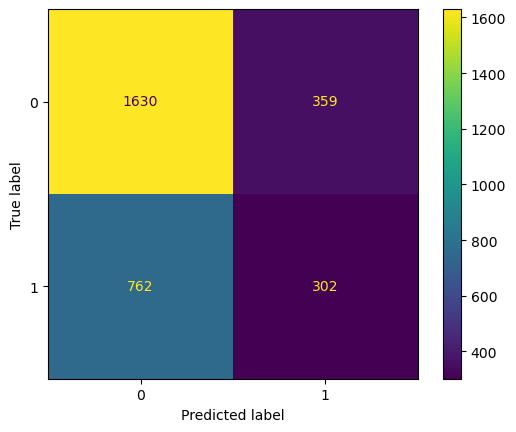

In [49]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, preds, labels=xgb1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb1.classes_)
disp.plot();

The model is twice as likely to predict a false negative than it is to predict a false positive. Therefore, type II errors are more common. For our use case, this would be more desirable, because it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one than to be disappointed by a low tip when they were expecting a generous one. However, it's unlikely that this model would be deployed further development to significantly improve its performance.

#### Feature importance

Use the `plot_importance` function to inspect the top 10 most important features of our final model.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

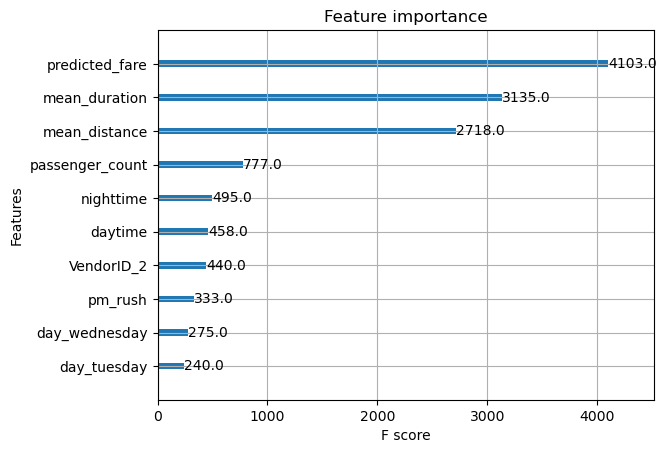

In [50]:
plot_importance(xgb1.best_estimator_, max_num_features=10)

<div></div>

## PACE: Execute

### **Task 4. Conclusion**

In this step, use the results of the models above to formulate a conclusion. Consider the following questions:

**1. Would you recommend using this model? Why or why not?**  
This is not a great model, but depending on how it's used it could still be useful. If the objective is only to help give taxi drivers a better idea of whether someone will leave a good tip, then it could be useful. It may be worthwhile to test it with a select group of taxi drivers to get feedback.

**2. What was your highest scoring model doing? Can you explain how it was making predictions?**   
Unfortunately, XGBoost is not the most transparent machine learning algorithm. We know that `predicted_fare`, `mean_duration` and `mean_distance` are the most important features, but we don't know how they influence tipping. This would require further exploration.

**3. Are there new features that you can engineer that might improve model performance?**   
There are almost always additional features that can be engineered, but hopefully the most obvious ones were generated during the first round of modeling. In our case, we could try creating three new columns that indicate if the trip distance is short, medium, or far. We could also engineer a column that gives a ratio that represents (the amount of money from the fare amount to the nearest higher multiple of $5) / fare amount. For example, if the fare were \\$12, the value in this column would be 0.25, because \\$12 to the nearest higher multiple of \\$5 (\\$15) is \\$3, and \\$3 divided by \\$12 is 0.25. The intuition for this feature is that people might be likely to simply round up their tip, so journeys with fares with values just under a multiple of \\$5 may have lower tip percentages than those with fare values just over a multiple of \\$5. We could also do the same thing for fares to the nearest \\$10.


$$round5\_ratio = \frac{amount\ of\ money\ from\ the\ fare\ amount\ to\ the\ nearest\ higher\ multiple\ of\ $5}{fare\ amount} = \frac{5 - (fare\ mod\ 5)}{fare\ amount}$$


**4. What features would you want to have that would likely improve the performance of your model?**   
It would probably be very helpful to have past tipping behavior for each customer. It would also be valuable to have accurate tip values for customers who pay with cash.
It would be helpful to have a lot more data. With enough data, we could create a unique feature for each pickup/dropoff combination.